In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
import cv2

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from tqdm import tqdm
from PIL import Image

In [36]:
HEIGHT = 137
WIDTH = 236

In [37]:
data_dir = '../input/bengaliai-cv19/'
files_train = [f'train_image_data_{fid}.parquet' for fid in range(4)]
files_train

['train_image_data_0.parquet',
 'train_image_data_1.parquet',
 'train_image_data_2.parquet',
 'train_image_data_3.parquet']

In [38]:
F = os.path.join(data_dir, files_train[1])
F

'../input/bengaliai-cv19/train_image_data_1.parquet'

In [39]:
train0 = pd.read_parquet(F)
train0.head()

,image_id,0,1,2,3,4,5,6,7,8,...,32322,32323,32324,32325,32326,32327,32328,32329,32330,32331
0,Train_50210,246,253,251,250,249,252,246,250,250,...,255,255,255,255,255,255,255,255,254,253
1,Train_50211,250,245,241,244,249,253,253,254,254,...,254,254,253,253,253,254,255,253,253,254
2,Train_50212,248,248,249,249,250,251,250,250,249,...,255,255,255,255,255,255,255,255,255,255
3,Train_50213,253,252,250,252,252,251,252,252,252,...,252,252,253,252,252,251,250,251,251,253
4,Train_50214,250,252,252,250,250,252,253,254,254,...,251,252,251,250,251,252,252,252,252,252


In [40]:
print(train0.shape)

(50210, 32333)


In [41]:
137*236

32332

# crop def

In [42]:
def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop_resize(img0, size=128, pad=16):

    #crop a box around pixels large than the threshold
    #some images contain line at the sides
    ymin,ymax,xmin,xmax = bbox(img0[5:-5,5:-5] > 80)
    #cropping may cut too much, so we need to add it back
    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT
    img = img0[ymin:ymax,xmin:xmax]
    #remove lo intensity pixels as noise
    img[img < 28] = 0
    lx, ly = xmax-xmin,ymax-ymin
    l = max(lx,ly) + pad
    #make sure that the aspect ratio is kept in rescaling
    img = np.pad(img, [((l-ly)//2,), ((l-lx)//2,)], mode='constant')
    return cv2.resize(img,(size,size))

# check one image

In [43]:
idx = 0
img = train0.iloc[idx, 1:].values.astype(np.uint8)

In [44]:
img

array([246, 253, 251, ..., 255, 254, 253], dtype=uint8)

In [45]:
img.reshape(137, 236).shape

(137, 236)

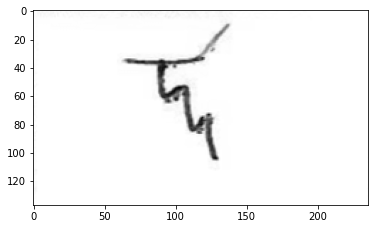

In [46]:
plt.imshow(img.reshape(137, 236), cmap='gray')

# check image with random

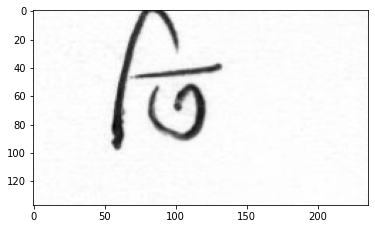

In [48]:
idx = np.random.randint(len(train0))
img = train0.iloc[idx, 1:].values.astype(np.uint8)

plt.imshow(img.reshape(137, 236), cmap='gray')

# multilabel stratified kfold

In [14]:
train_label = pd.read_csv(data_dir + 'train.csv')
train_label.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো


In [15]:
train_label.tail()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো
200839,Train_200839,127,2,0,ল্টি


In [16]:
# plt.figure(figsize=(10,20))
# train_label['grapheme_root'].value_counts().sort_index().plot.barh()

In [17]:
# plt.figure(figsize=(10,20))
# train_label['vowel_diacritic'].value_counts().sort_index().plot.barh()

In [18]:
# plt.figure(figsize=(10,20))
# train_label['consonant_diacritic'].value_counts().sort_index().plot.barh()

In [19]:
train_label['id'] = train_label['image_id'].apply(lambda x : int(x.split('_')[1]))

In [20]:
train_label.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id
0,Train_0,15,9,5,ক্ট্রো,0
1,Train_1,159,0,0,হ,1
2,Train_2,22,3,5,খ্রী,2
3,Train_3,53,2,2,র্টি,3
4,Train_4,71,9,5,থ্রো,4


In [21]:
X = train_label[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values[:,0]
y = train_label[['id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values[:,1:]

In [22]:
mskf = MultilabelStratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [23]:
train_label['fold'] = -1

In [24]:
for i, (trn_idx, val_idx) in enumerate(mskf.split(X, y)):
    train_label.loc[val_idx, 'fold'] = i

In [25]:
train_label

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,id,fold
0,Train_0,15,9,5,ক্ট্রো,0,2
1,Train_1,159,0,0,হ,1,3
2,Train_2,22,3,5,খ্রী,2,1
3,Train_3,53,2,2,র্টি,3,4
4,Train_4,71,9,5,থ্রো,4,2
...,...,...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে,200835,1
200836,Train_200836,65,9,0,ত্তো,200836,2
200837,Train_200837,2,1,4,অ্যা,200837,0
200838,Train_200838,152,9,0,স্নো,200838,3


In [26]:
train_label['fold'].value_counts()

4    40168
3    40168
2    40168
1    40168
0    40168
Name: fold, dtype: int64

In [27]:
# train_label.to_csv(data_dir+'train_label_folds.csv', index=False)

In [28]:
for fname in files_train:
    F = os.path.join(data_dir, fname)
    df_train = pd.read_parquet(F)
    img_ids = df_train['image_id'].values
    img_array = df_train.iloc[:, 1:].values
    
    for idx in tqdm(range(len(df_train))):
        img_id = img_ids[idx]
        img = img_array[idx]
        img = 255 - img.reshape(137, 236)
        crop = crop_resize(img)
        crop_im = Image.fromarray(crop)
        crop_im.save(f'../input/bengaliai-cv19/train_crop_image/{img_id}.jpg')
#         joblib.dump(img, f'../input/bengaliai-cv19/train_image/{img_id}.pkl')

100%|██████████| 50210/50210 [00:23<00:00, 2157.52it/s]


In [29]:
# F = os.path.join(data_dir, files_train[0])
# df_train = pd.read_parquet(F)

In [30]:
# df_train.head()

In [31]:
# img_ids = df_train['image_id'].values
# img_array = df_train.iloc[:, 1:].values

In [32]:
# img_array.shape

In [33]:
# for idx in tqdm(range(len(df_train))):
#     break

In [34]:
# img_id = img_ids[idx]
# img = img_array[idx]

# joblib.dump(img, f'../input/bengaliai-cv19/train_images/{img_id}.pkl')